In [12]:
from distutils.command.build import build
from multiprocessing.sharedctypes import Value
from joblib.logger import Logger
from main import parser
from copy import deepcopy
import os
import types
import pickle

import torch

import numpy as np
from tqdm import tqdm
import seaborn as sns

import evals

from mpvae import VAE, compute_loss
from data import load_data, load_data_masked
from utils import search_files, build_path
from logger import Logger
from fairsoft_trial import IMPLEMENTED_METHODS

import matplotlib.pyplot as plt

In [13]:
def extract_f1(model, reg_norm, dataset, fair_coeff=1, target_fair_label=0, seed=1):
    model_path = f'./new_fair_through_distance/model/{dataset}/probability/'

    if model == 'unfair':
        model_file = os.path.join(
            model_path, f'unfair', f'unfair_vae_prior-{fair_coeff:.2f}_{seed:04d}.pkl')
    elif model in ['indication', 'elementwise', 'constant']:
        model_file = os.path.join(
                model_path, f'baseline_{target_fair_label}', f'fair_vae_prior-{model}-{reg_norm}_reg-{fair_coeff:.2f}_{seed:-04d}.pkl')
    elif 'jaccard' in model:
         model_file = os.path.join(
                model_path, f'jaccard_{target_fair_label}', f'fair_vae_prior-{model}-{reg_norm}_reg-{fair_coeff:.2f}_{seed:-04d}.pkl')
            
    results = pickle.load(open(model_file, 'rb'))
    results = results['valid']
    is_target = np.concatenate(results['is_target_label'])
    
    labels = results['y_reals']
    preds = results['y_probs']
    preds = (preds >= 0.5).astype(int)

    micro_f1s, macro_f1s = [], []
    for label, pred in zip(labels.T, preds.T):
        micro_f1 = evals.f1_score(label.reshape(-1, 1), pred.reshape(-1, 1), average='micro')
        macro_f1 = evals.f1_score(label.reshape(-1, 1), pred.reshape(-1, 1), average='macro')
        micro_f1s.append(micro_f1)
        macro_f1s.append(macro_f1)
#     print(evals.f1_score(labels, preds, average='micro'))
#     print(evals.f1_score(labels, preds, average='macro'))
    
    return labels.mean(0), np.array(macro_f1s)

In [14]:
def extract_f1(model, reg_norm, dataset, fair_coeff=1, target_fair_label=0, seed=1):
    model_path = f'./new_fair_through_distance/model/{dataset}/probability/'

    if model == 'unfair':
        model_file = os.path.join(
            model_path, f'unfair', f'unfair_vae_prior-{fair_coeff:.2f}_{seed:04d}.pkl')
    elif model in ['indication', 'elementwise', 'constant']:
        model_file = os.path.join(
                model_path, f'baseline_{target_fair_label}', f'fair_vae_prior-{model}-{reg_norm}_reg-{fair_coeff:.2f}_{seed:-04d}.pkl')
    elif 'jaccard' in model:
         model_file = os.path.join(
                model_path, f'jaccard_{target_fair_label}', f'fair_vae_prior-{model}-{reg_norm}_reg-{fair_coeff:.2f}_{seed:-04d}.pkl')
            
    results = pickle.load(open(model_file, 'rb'))
    results = results['valid']
    is_target = np.concatenate(results['is_target_label'])
    
    labels = results['y_reals']
    preds = results['y_probs']
    preds = (preds >= 0.5).astype(int)

    micro_f1s, macro_f1s = [], []
    for label, pred in zip(labels.T, preds.T):
        micro_f1 = evals.f1_score(label.reshape(-1, 1), pred.reshape(-1, 1), average='micro')
        macro_f1 = evals.f1_score(label.reshape(-1, 1), pred.reshape(-1, 1), average='macro')
        micro_f1s.append(micro_f1)
        macro_f1s.append(macro_f1)
    
    return labels.mean(0), np.array(macro_f1s)

In [23]:
def extract_probs(model, reg_norm, dataset, fair_coeff=1, return_only_target=True, target_fair_label=0, seed=1):
    model_path = f'./new_fair_through_distance/model/{dataset}/probability/'

    if model == 'unfair':
        model_file = os.path.join(
            model_path, f'unfair', f'unfair_vae_prior-{fair_coeff:.2f}_{seed:-04d}.pkl')
    elif model in ['indication', 'elementwise', 'constant']:
        model_file = os.path.join(
                model_path, f'baseline_{target_fair_label}', f'fair_vae_prior-{model}-{reg_norm}_reg-{fair_coeff:.2f}_{seed:-04d}.pkl')
    elif 'jaccard' in model:
         model_file = os.path.join(
                model_path, f'jaccard_{target_fair_label}', f'fair_vae_prior-{model}-{reg_norm}_reg-{fair_coeff:.2f}_{seed:-04d}.pkl')
            
    results = pickle.load(open(model_file, 'rb'))
    results = results['valid']
    is_target = np.concatenate(results['is_target_label'])
    sensitive = np.concatenate(results['sensitive_idx'])

    labels = results['y_reals']
    probs = results['y_probs']
    
    if return_only_target:
        probs = probs[is_target]
        sensitive = sensitive[is_target]
    return probs, sensitive

# adult

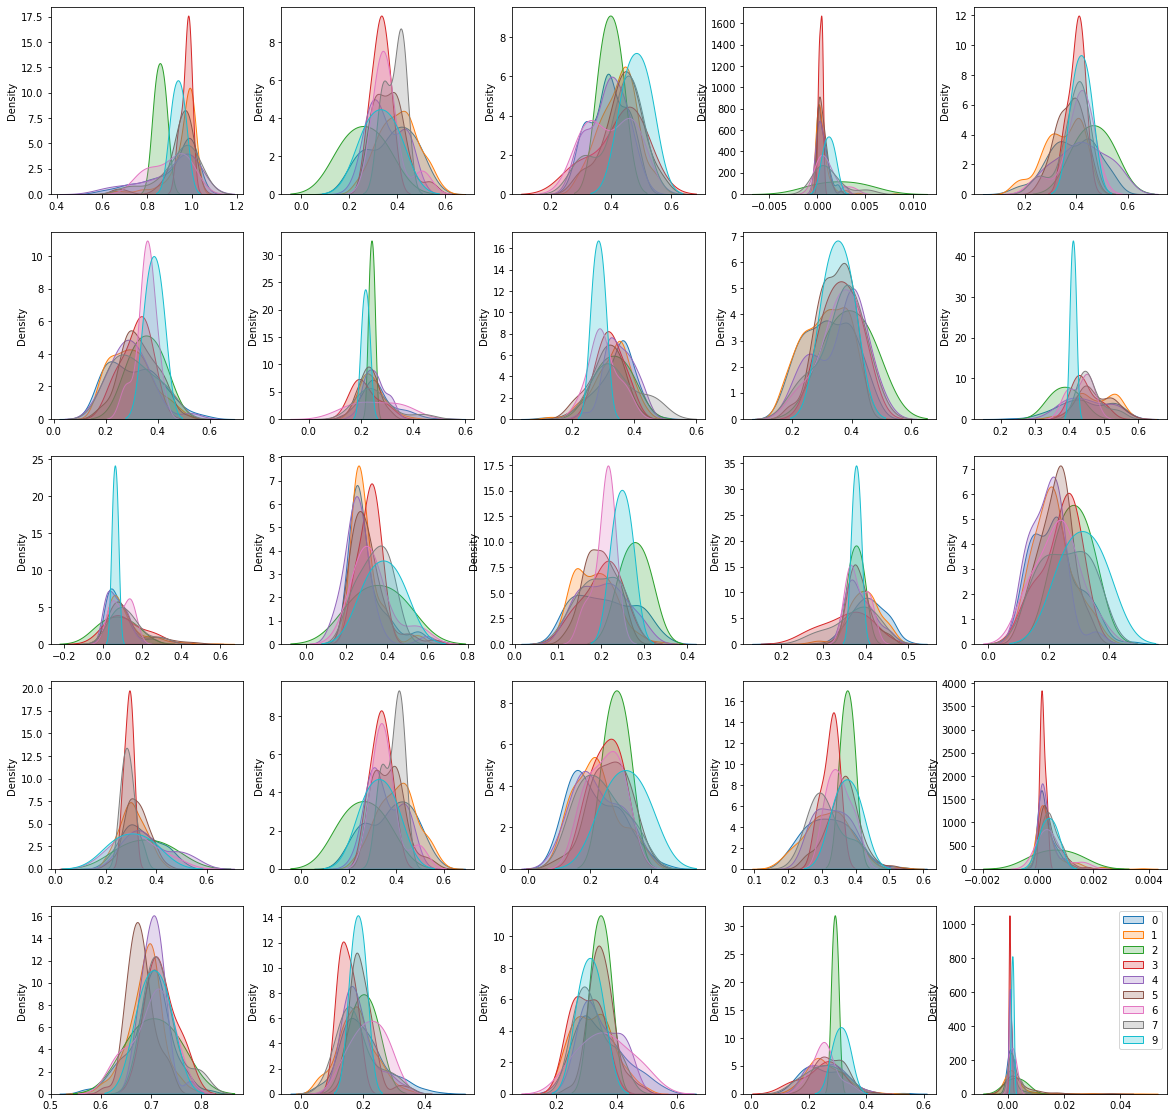

In [26]:
probs, sen_idx = extract_probs('constant', 'l2', 'adult')
n_labels = probs.shape[1]
ncols = 5
nrows = n_labels // ncols + 1 * n_labels % ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))

idxs = np.arange(len(probs))
for idx in range(sen_idx.shape[1]):
    idx_st = str(idx)
    sen_idxs = idxs[sen_idx[:, idx]]
    probs_sen = probs[sen_idxs]
    for i in np.arange(n_labels):
        ax = axes[i // ncols, i % ncols]
        sns.kdeplot(probs_sen[:, i], label=idx_st, ax=ax, fill=idx_st, warn_singular=False)

plt.legend()

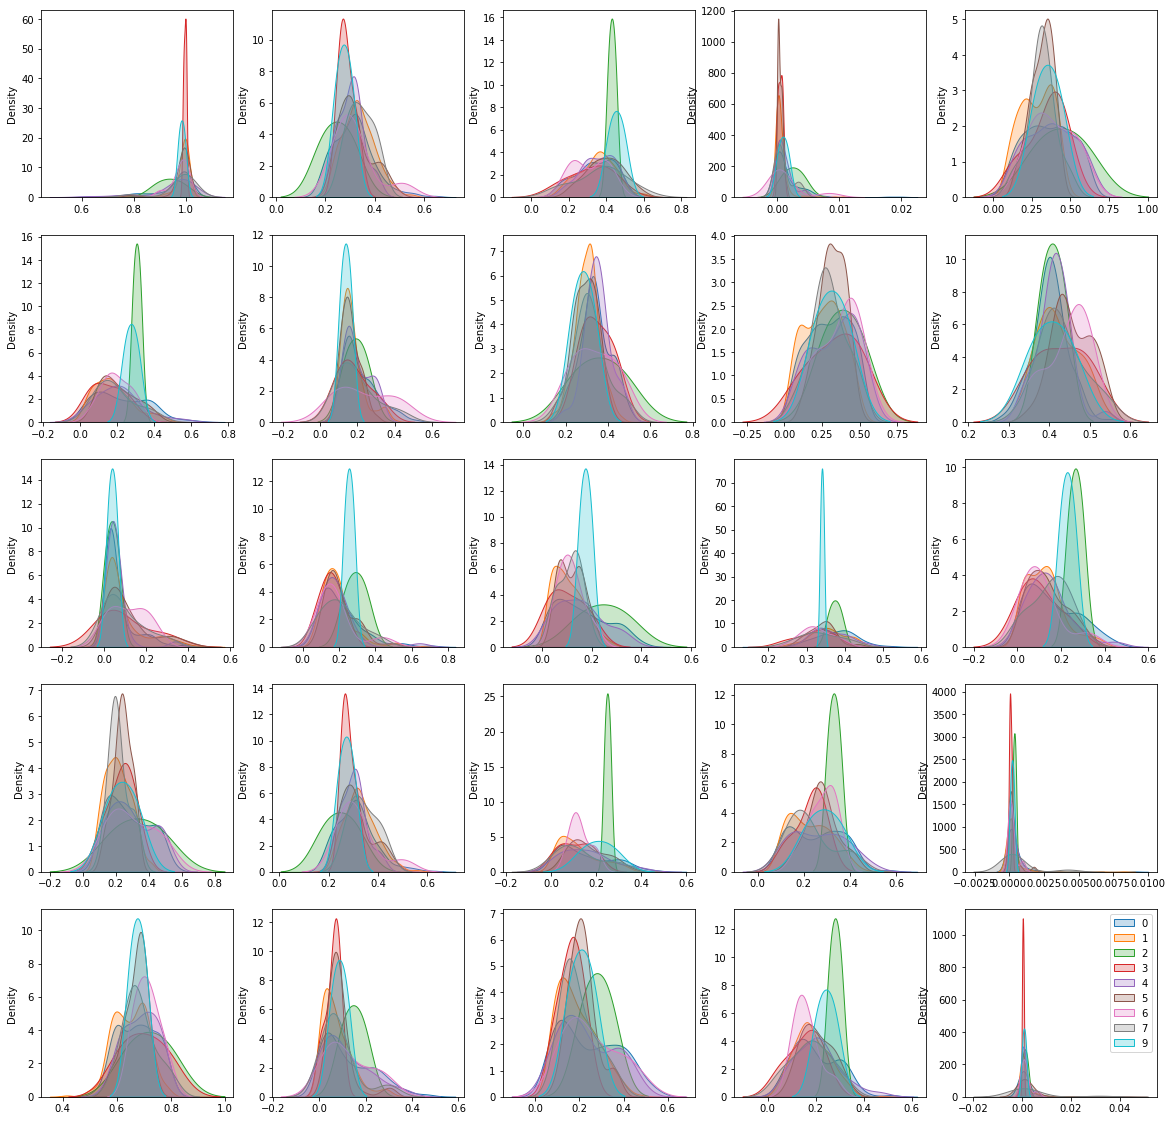

In [25]:
probs, sen_idx = extract_probs('unfair', 'l2', 'adult')
n_labels = probs.shape[1]
ncols = 5
nrows = n_labels // ncols + 1 * n_labels % ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))

idxs = np.arange(len(probs))
for idx in range(sen_idx.shape[1]):
    idx_st = str(idx)
    sen_idxs = idxs[sen_idx[:, idx]]
    probs_sen = probs[sen_idxs]
    for i in np.arange(n_labels):
        ax = axes[i // ncols, i % ncols]
        sns.kdeplot(probs_sen[:, i], label=idx_st, ax=ax, fill=idx_st, warn_singular=False)

plt.legend()

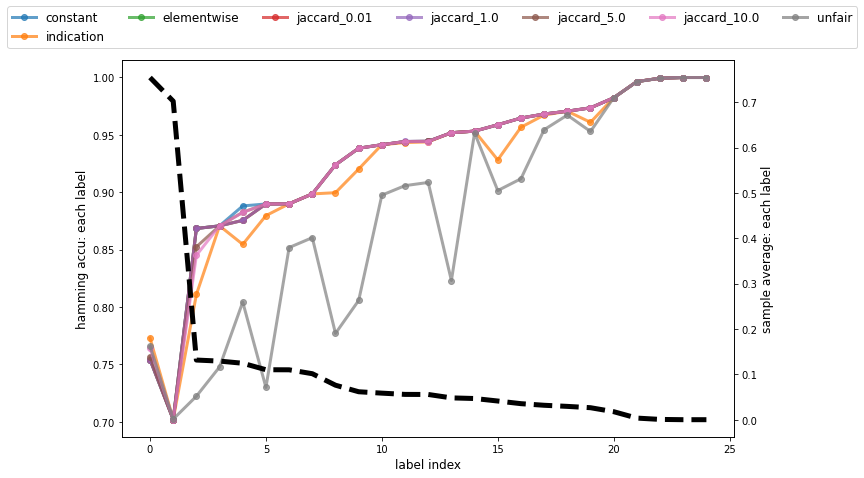

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax2 = ax.twinx()

for model in ['constant', 'indication', 'elementwise', 'jaccard_0.01', 'jaccard_1.0', 'jaccard_5.0', 'jaccard_10.0', 'unfair']:
    label_avg, pred_avg, accu = extract_ham_accu(model, 'l2', 'adult', fair_coeff=1000, target_fair_label=0)
    label_dense_idx = np.argsort(-label_avg)    
    ax.plot(accu[label_dense_idx], 'o-', label=model, linewidth=3, alpha=.7)
    # ax2.plot(pred_avg[label_dense_idx], '--', label=model, linewidth=3, alpha=.7)

ax2.plot(label_avg[label_dense_idx], '--', color='black', linewidth=5)
_, label1 = ax.get_legend_handles_labels()

_ = fig.legend(loc='upper center', labels=label1, bbox_to_anchor=(.51, 1.1), borderaxespad=0, ncol=7, fontsize=12)
ax.set_ylabel('hamming accu: each label', fontsize=12)
ax2.set_ylabel('sample average: each label', fontsize=12)
ax.set_xlabel('label index', fontsize=12)

plt.tight_layout()

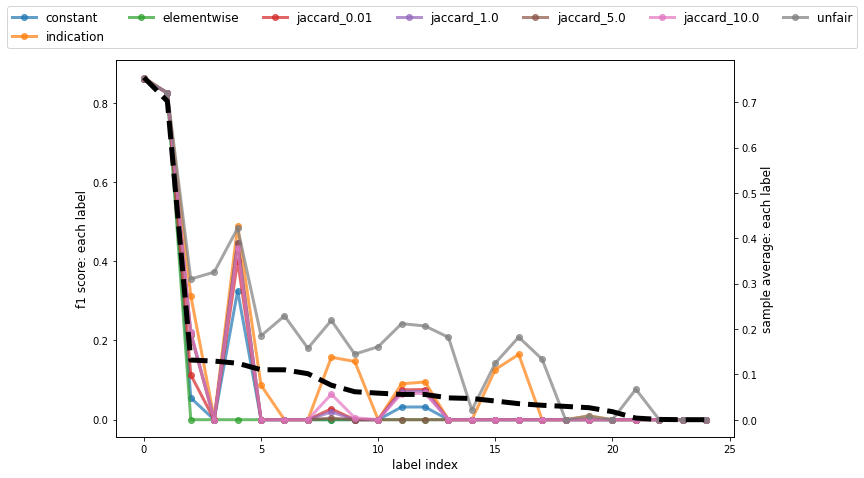

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

for model in ['constant', 'indication', 'elementwise', 'jaccard_0.01', 'jaccard_1.0', 'jaccard_5.0', 'jaccard_10.0', 'unfair']:
    label_avg, accu = extract_f1(model, 'l2', 'adult', fair_coeff=100, target_fair_label=0)
    label_dense_idx = np.argsort(-label_avg)    
    ax.plot(accu[label_dense_idx], 'o-', label=model, linewidth=3, alpha=.7)

ax2 = ax.twinx()
ax2.plot(label_avg[label_dense_idx], '--', color='black', linewidth=5)
_, label1 = ax.get_legend_handles_labels()
# _, label2 = ax2.get_legend_handles_labels()
# ax.set_xticklabels(label_avg)
_ = fig.legend(loc='upper center', labels=label1, bbox_to_anchor=(.51, 1.1), borderaxespad=0, ncol=7, fontsize=12)
ax.set_ylabel('f1 score: each label', fontsize=12)
ax2.set_ylabel('sample average: each label', fontsize=12)
ax.set_xlabel('label index', fontsize=12)
plt.tight_layout()

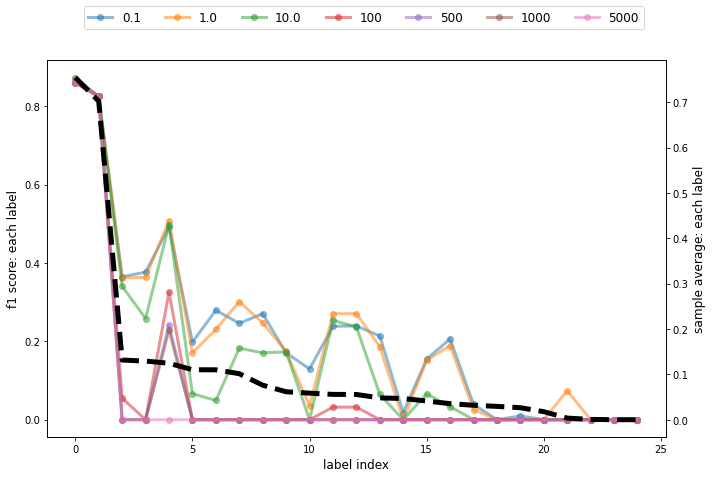

In [6]:
# plt.rcParams['svg.fonttype'] = 'none'

# from IPython.display import set_matplotlib_formats
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# from cycler import cycler
# mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

for coeff in [0.1, 1., 10., 100, 500, 1000, 5000]:
    model = 'constant'
    label_avg, accu = extract_f1(model, 'l2', 'adult', fair_coeff=coeff)
    label_dense_idx = np.argsort(-label_avg)    
    ax.plot(accu[label_dense_idx], 'o-', label=coeff, linewidth=3, alpha=.5)

ax2 = ax.twinx()
ax2.plot(label_avg[label_dense_idx], '--', color='black', linewidth=5)
_, label1 = ax.get_legend_handles_labels()
_, label2 = ax2.get_legend_handles_labels()
_ = fig.legend(loc='upper center', labels=label1+label2, bbox_to_anchor=(.51, 1.1), borderaxespad=0, ncol=7, fontsize=12)
ax.set_ylabel('f1 score: each label', fontsize=12)
ax2.set_ylabel('sample average: each label', fontsize=12)
ax.set_xlabel('label index', fontsize=12)
plt.tight_layout()

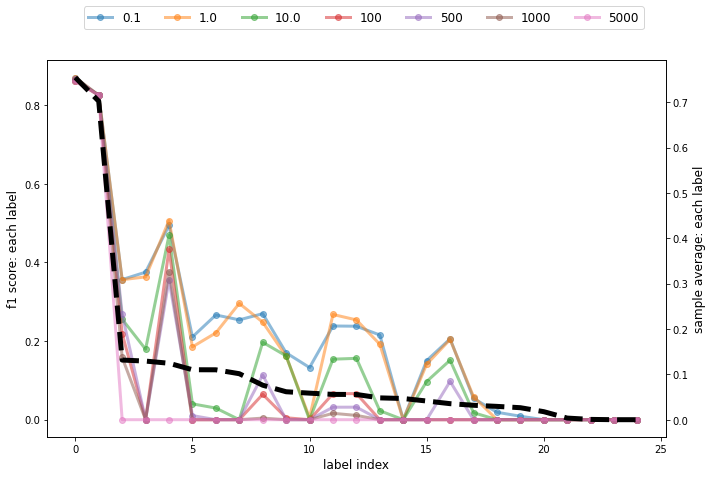

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

for coeff in [0.1, 1., 10., 100, 500, 1000, 5000]:
    model = 'jaccard_10.0'
    label_avg, accu = extract_f1(model, 'l2', 'adult', fair_coeff=coeff)
    label_dense_idx = np.argsort(-label_avg)    
    ax.plot(accu[label_dense_idx], 'o-', label=coeff, linewidth=3, alpha=.5)

ax2 = ax.twinx()
ax2.plot(label_avg[label_dense_idx], '--', color='black', linewidth=5)
_, label1 = ax.get_legend_handles_labels()
_, label2 = ax2.get_legend_handles_labels()
_ = fig.legend(loc='upper center', labels=label1+label2, bbox_to_anchor=(.51, 1.1), borderaxespad=0, ncol=7, fontsize=12)
ax.set_ylabel('f1 score: each label', fontsize=12)
ax2.set_ylabel('sample average: each label', fontsize=12)
ax.set_xlabel('label index', fontsize=12)
plt.tight_layout()

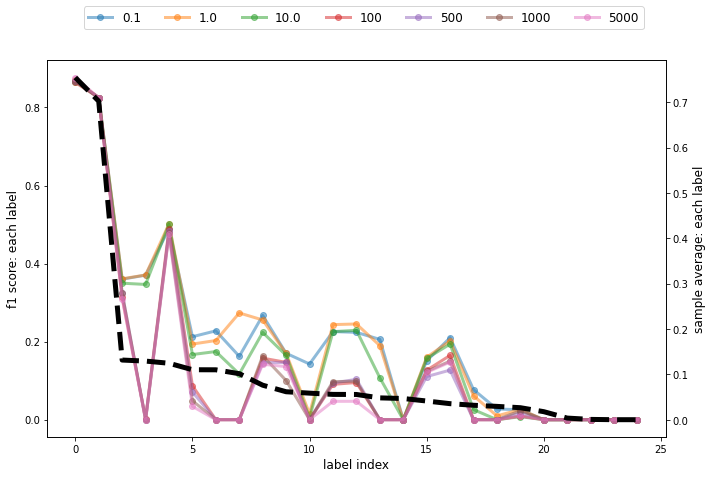

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

for coeff in [0.1, 1., 10., 100, 500, 1000, 5000]:
    model = 'indication'
    label_avg, accu = extract_f1(model, 'l2', 'adult', fair_coeff=coeff)
    label_dense_idx = np.argsort(-label_avg)    
    ax.plot(accu[label_dense_idx], 'o-', label=coeff, linewidth=3, alpha=.5)

ax2 = ax.twinx()
ax2.plot(label_avg[label_dense_idx], '--', color='black', linewidth=5)
_, label1 = ax.get_legend_handles_labels()
_, label2 = ax2.get_legend_handles_labels()
_ = fig.legend(loc='upper center', labels=label1+label2, bbox_to_anchor=(.51, 1.1), borderaxespad=0, ncol=7, fontsize=12)
ax.set_ylabel('f1 score: each label', fontsize=12)
ax2.set_ylabel('sample average: each label', fontsize=12)
ax.set_xlabel('label index', fontsize=12)
plt.tight_layout()

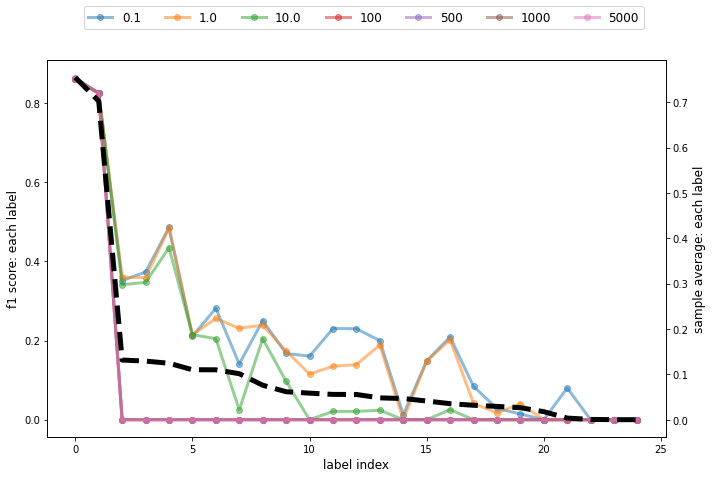

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

for coeff in [0.1, 1., 10., 100, 500, 1000, 5000]:
    model = 'elementwise'
    label_avg, accu = extract_f1(model, 'l2', 'adult', fair_coeff=coeff)
    label_dense_idx = np.argsort(-label_avg)    
    ax.plot(accu[label_dense_idx], 'o-', label=coeff, linewidth=3, alpha=.5)

ax2 = ax.twinx()
ax2.plot(label_avg[label_dense_idx], '--', color='black', linewidth=5)
_, label1 = ax.get_legend_handles_labels()
_, label2 = ax2.get_legend_handles_labels()
_ = fig.legend(loc='upper center', labels=label1+label2, bbox_to_anchor=(.51, 1.1), borderaxespad=0, ncol=7, fontsize=12)
ax.set_ylabel('f1 score: each label', fontsize=12)
ax2.set_ylabel('sample average: each label', fontsize=12)
ax.set_xlabel('label index', fontsize=12)
plt.tight_layout()

# credit

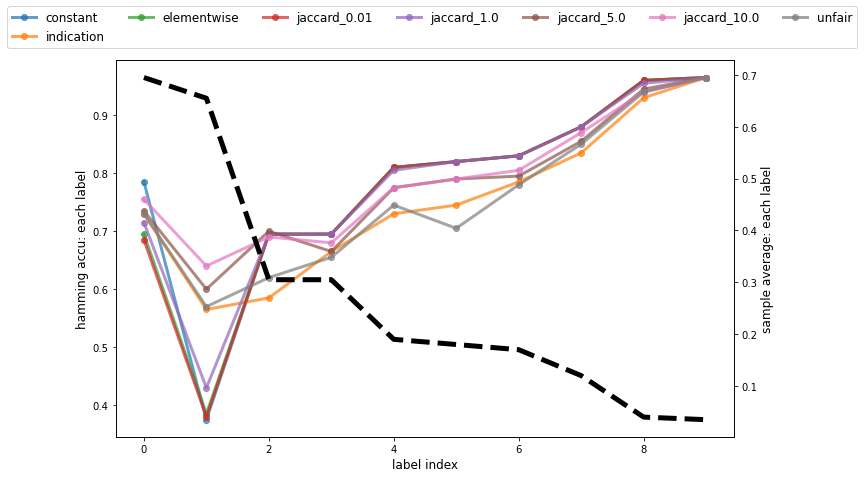

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax2 = ax.twinx()

for model in ['constant', 'indication', 'elementwise', 'jaccard_0.01', 'jaccard_1.0', 'jaccard_5.0', 'jaccard_10.0', 'unfair']:
    label_avg, pred_avg, accu = extract_ham_accu(model, 'l2', 'credit', fair_coeff=1000, target_fair_label=0)
    label_dense_idx = np.argsort(-label_avg)    
    ax.plot(accu[label_dense_idx], 'o-', label=model, linewidth=3, alpha=.7)
    # ax2.plot(pred_avg[label_dense_idx], '--', label=model, linewidth=3, alpha=.7)

ax2.plot(label_avg[label_dense_idx], '--', color='black', linewidth=5)
_, label1 = ax.get_legend_handles_labels()

_ = fig.legend(loc='upper center', labels=label1, bbox_to_anchor=(.51, 1.1), borderaxespad=0, ncol=7, fontsize=12)
ax.set_ylabel('hamming accu: each label', fontsize=12)
ax2.set_ylabel('sample average: each label', fontsize=12)
ax.set_xlabel('label index', fontsize=12)

plt.tight_layout()

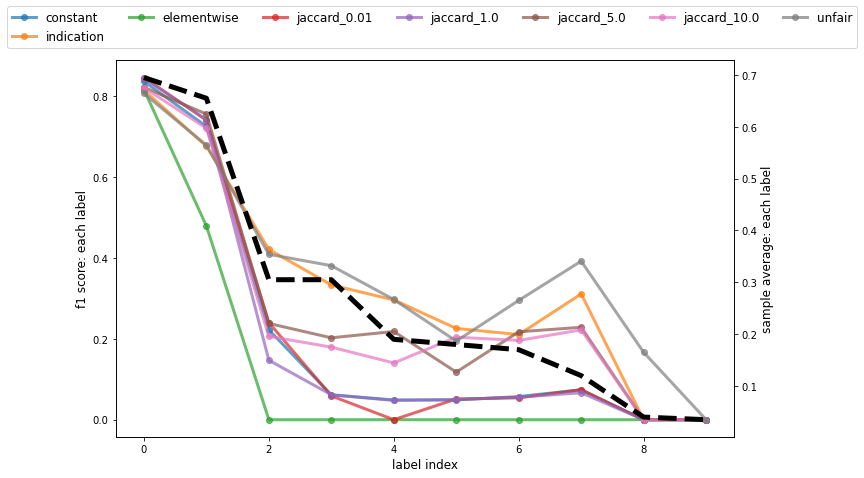

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

for model in ['constant', 'indication', 'elementwise', 'jaccard_0.01', 'jaccard_1.0', 'jaccard_5.0', 'jaccard_10.0', 'unfair']:
    label_avg, accu = extract_f1(model, 'l2', 'credit', fair_coeff=100, target_fair_label=0)
    label_dense_idx = np.argsort(-label_avg)    
    ax.plot(accu[label_dense_idx], 'o-', label=model, linewidth=3, alpha=.7)

ax2 = ax.twinx()
ax2.plot(label_avg[label_dense_idx], '--', color='black', linewidth=5)
_, label1 = ax.get_legend_handles_labels()
# _, label2 = ax2.get_legend_handles_labels()
# ax.set_xticklabels(label_avg)
_ = fig.legend(loc='upper center', labels=label1, bbox_to_anchor=(.51, 1.1), borderaxespad=0, ncol=7, fontsize=12)
ax.set_ylabel('f1 score: each label', fontsize=12)
ax2.set_ylabel('sample average: each label', fontsize=12)
ax.set_xlabel('label index', fontsize=12)
plt.tight_layout()

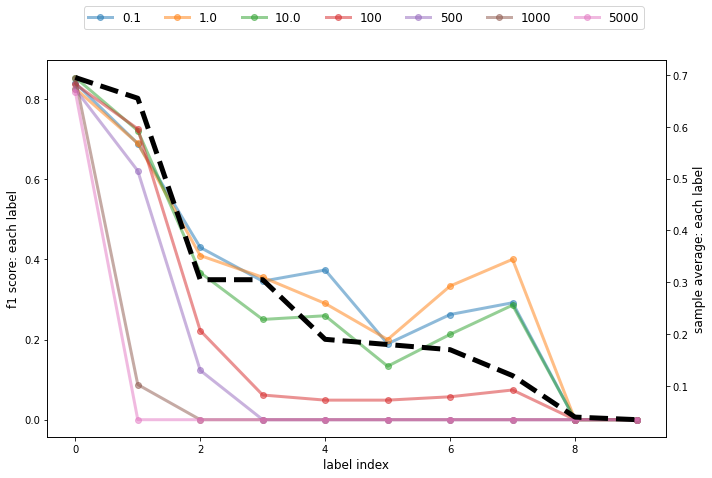

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

for coeff in [0.1, 1., 10., 100, 500, 1000, 5000]:
    model = 'constant'
    label_avg, accu = extract_f1(model, 'l2', 'credit', fair_coeff=coeff)
    label_dense_idx = np.argsort(-label_avg)    
    ax.plot(accu[label_dense_idx], 'o-', label=coeff, linewidth=3, alpha=.5)

ax2 = ax.twinx()
ax2.plot(label_avg[label_dense_idx], '--', color='black', linewidth=5)
_, label1 = ax.get_legend_handles_labels()
_, label2 = ax2.get_legend_handles_labels()
_ = fig.legend(loc='upper center', labels=label1+label2, bbox_to_anchor=(.51, 1.1), borderaxespad=0, ncol=7, fontsize=12)
ax.set_ylabel('f1 score: each label', fontsize=12)
ax2.set_ylabel('sample average: each label', fontsize=12)
ax.set_xlabel('label index', fontsize=12)
plt.tight_layout()

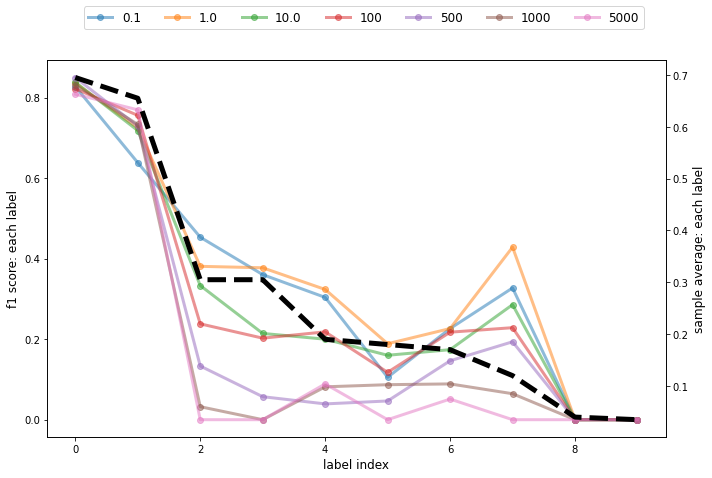

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

for coeff in [0.1, 1., 10., 100, 500, 1000, 5000]:
    model = 'jaccard_5.0'
    label_avg, accu = extract_f1(model, 'l2', 'credit', fair_coeff=coeff)
    label_dense_idx = np.argsort(-label_avg)    
    ax.plot(accu[label_dense_idx], 'o-', label=coeff, linewidth=3, alpha=.5)

ax2 = ax.twinx()
ax2.plot(label_avg[label_dense_idx], '--', color='black', linewidth=5)
_, label1 = ax.get_legend_handles_labels()
_, label2 = ax2.get_legend_handles_labels()
_ = fig.legend(loc='upper center', labels=label1+label2, bbox_to_anchor=(.51, 1.1), borderaxespad=0, ncol=7, fontsize=12)
ax.set_ylabel('f1 score: each label', fontsize=12)
ax2.set_ylabel('sample average: each label', fontsize=12)
ax.set_xlabel('label index', fontsize=12)
plt.tight_layout()

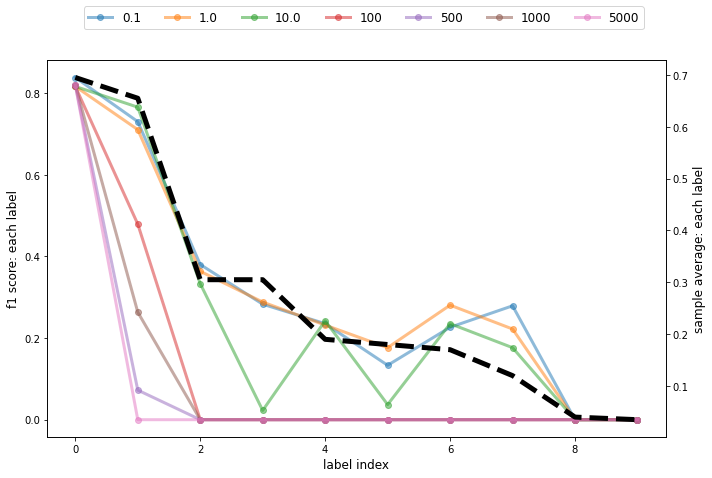

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

for coeff in [0.1, 1., 10., 100, 500, 1000, 5000]:
    model = 'elementwise'
    label_avg, accu = extract_f1(model, 'l2', 'credit', fair_coeff=coeff)
    label_dense_idx = np.argsort(-label_avg)    
    ax.plot(accu[label_dense_idx], 'o-', label=coeff, linewidth=3, alpha=.5)

ax2 = ax.twinx()
ax2.plot(label_avg[label_dense_idx], '--', color='black', linewidth=5)
_, label1 = ax.get_legend_handles_labels()
_, label2 = ax2.get_legend_handles_labels()
_ = fig.legend(loc='upper center', labels=label1+label2, bbox_to_anchor=(.51, 1.1), borderaxespad=0, ncol=7, fontsize=12)
ax.set_ylabel('f1 score: each label', fontsize=12)
ax2.set_ylabel('sample average: each label', fontsize=12)
ax.set_xlabel('label index', fontsize=12)
plt.tight_layout()